In [1]:
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imp import reload
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression as LR

import cca
from cca import ComplexityComponentsAnalysis as CCA
from cca import methods_comparison as mc
from cca import synth_data

# Comparison with PCA

From an analysis perspective, the goal of PCA is to find the subspace that maximizes the projected variance of the data. If the dimensions with dynamics have low variance compared to the noise dimensions, PCA will not recover the dynamics.

Here, we show this on a dataset where the first two dimensions are GPs with different kernels and kernel parameters and variance=1. The second two dimensions are multivariate noise with variances 5 and 2 respectively.

In [ ]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.01)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('exp', spatial_scale=2., temporal_scale=5., local_noise=.01)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
X3 = np.random.multivariate_normal([0., 0.], [[5., 0.], [0., 2]], size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [ ]:
pca = PCA(n_components=2).fit(X)
print(pca.components_.T)
print(subspace_angles(proj, pca.components_.T))

In [ ]:
cca = CCA(d=1, T=5, n_init=5).fit(X)
print(cca.coef_)

cca = CCA(d=2, T=5, n_init=5).fit(X)
print(cca.coef_)
print(subspace_angles(proj, cca.coef_))

# Comparison to SFA
SFA is only sensitive to the autocorrelation at one time-lag wheras DCA is sensitive to all auto and crosscorrelations at up to 2T time-lags.

In [17]:
T = 50
noise = .01
taus = np.linspace(.9, 1., 100)
gauss_pi = np.zeros_like(taus)
exp_pi = np.zeros_like(taus)
gauss_ac1 = np.zeros_like(taus)
exp_ac1 = np.zeros_like(taus)

In [18]:
for ii, tau in enumerate(taus):
    gauss_k = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau)
    exp_k = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    gauss_cov = synth_data.gen_gp_cov(gauss_k, T, 1)
    exp_cov = synth_data.gen_gp_cov(exp_k, T, 1)
    gauss_ac1[ii] = gauss_cov[0, 1]
    exp_ac1[ii] = exp_cov[0, 1]
    gauss_pi[ii] = synth_data.calc_pi_for_gp(gauss_k, T, 1)
    exp_pi[ii] = synth_data.calc_pi_for_gp(exp_k, T, 1)

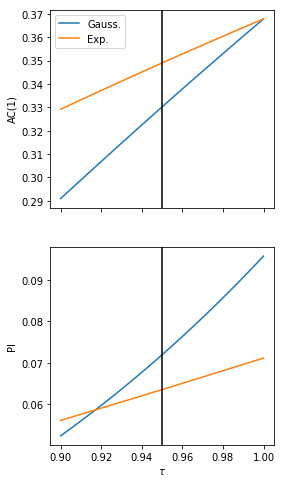

In [19]:
tau = .95
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 8))
ax1.plot(taus, gauss_ac1, label='Gauss.')
ax1.plot(taus, exp_ac1, label='Exp.')
ax1.set_ylabel('AC(1)')
ax1.axvline(tau, 0, 1, c='k')
ax1.legend(loc='best')

ax2.plot(taus, gauss_pi)
ax2.plot(taus, exp_pi)
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel('PI')
ax2.axvline(tau, 0, 1, c='k')

In [20]:
n_samples = 1000
GP1_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau)
GP2_ker = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
X1 = synth_data.sample_gp(n_samples, 1, GP1_ker, num_to_concat=10) * 2.
X2 = synth_data.sample_gp(n_samples, 1, GP2_ker, num_to_concat=10)
#X2 = np.random.randn(n_samples, 1)
X = np.concatenate([X1, X2], axis=1)

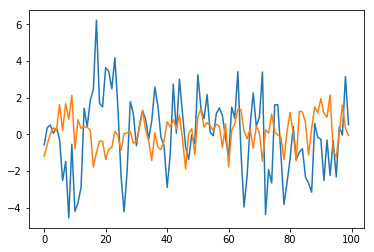

In [21]:
plt.plot(X1[:100])
plt.plot(X2[:100])

In [22]:
reload(mc)
sfa_model = mc.SlowFeatureAnalysis(1).fit(X)
print(sfa_model.coef_)

[[-0.08550661]
 [-0.9963376 ]]


In [23]:
cca_model = CCA(d=1, T=1, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.08314083]
 [-0.99653781]]


In [24]:
cca_model = CCA(d=1, T=2, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.9960485 ]
 [-0.08881093]]


# Comparison with GPFA

In [13]:
def gen_gp_concat_noise(n_samples, n_concat):
    GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=1., local_noise=.001)
    X1 = synth_data.sample_gp(n_samples, 1, GP_ker, num_to_concat=n_concat)
    GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=2., local_noise=.001)
    X2 = synth_data.sample_gp(n_samples, 1, GP_ker, num_to_concat=n_concat)
    mu = np.zeros(4)
    cov = np.diag([10, 8, 2, 1])
    X3 = np.random.multivariate_normal(mu, cov, size=n_samples * n_concat)
    X = np.concatenate([X1, X2, X3], axis=1)
    return X

In [14]:
n_samples = 200
n_concat = 1
X = gen_gp_concat_noise(n_samples, n_concat)
Xtest = gen_gp_concat_noise(n_samples, n_concat)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [15]:
n_samples = np.array([100, 250, 500, 1000])
tols = np.logspace(-2, -.4, 3)
n_repeat = 3
r2 = np.zeros((2, tols.size, n_repeat, 2))
times = np.zeros((2, tols.size, n_repeat))

for ii, tol in enumerate(tols):
    for jj in range(n_repeat):
        print(tol, jj)
        start = time.time()
        gpfa = mc.GaussianProcessFactorAnalysis(n_factors=2, tol=tol)
        gpfa.fit(X)
        times[0, ii, jj] = time.time() - start
        proj = gpfa.transform(X)
        model = LR().fit(proj, X[:, :2])
        r2[0, ii, jj, 0] = model.score(proj, X[:, :2])
        proj = gpfa.transform(Xtest)
        r2[0, ii, jj, 1] = model.score(proj, Xtest[:, :2])
        print(tol, jj)
        start = time.time()
        cca_model = cca.ComplexityComponentsAnalysis(d=2, T=5, tol=tol)
        cca_model.estimate_cross_covariance(X, regularization='kron')
        cca_model.fit_projection()
        times[1, ii, jj] = time.time() - start
        proj = cca_model.transform(X)
        model = LR().fit(proj, X[:, :2])
        r2[1, ii, jj, 0] = model.score(proj, X[:, :2])
        proj = cca_model.transform(Xtest)
        r2[1, ii, jj, 1] = model.score(proj, Xtest[:, :2])

0.01 0
0.01 0
0.01 1
0.01 1
0.01 2
0.01 2
0.06309573444801933 0
0.06309573444801933 0
0.06309573444801933 1
0.06309573444801933 1
0.06309573444801933 2
0.06309573444801933 2
0.3981071705534972 0
0.3981071705534972 0
0.3981071705534972 1
0.3981071705534972 1
0.3981071705534972 2
0.3981071705534972 2


In [19]:
r2

array([[[[ 0.57207089,  0.53104133],
         [ 0.57207089,  0.5301322 ],
         [ 0.57207089,  0.5301322 ]],

        [[ 0.56527113,  0.52031758],
         [ 0.56527113,  0.52031758],
         [ 0.56527113,  0.52031758]],

        [[ 0.24165678,  0.1517867 ],
         [ 0.24165678,  0.1517867 ],
         [ 0.24165678,  0.1517867 ]]],


       [[[ 0.18315247,  0.17595479],
         [ 0.47901904,  0.391021  ],
         [ 0.17349022,  0.07725994]],

        [[ 0.42792798,  0.39910884],
         [ 0.1733991 ,  0.06171397],
         [ 0.14988161,  0.21487461]],

        [[ 0.1520186 ,  0.0556937 ],
         [ 0.0193014 , -0.02181931],
         [ 0.04138898, -0.0066595 ]]]])

In [20]:
times

array([[[54.53137302, 57.02763891, 56.68244314],
        [38.14583898, 36.92247748, 37.12610292],
        [ 1.54227495,  1.47397065,  1.47143984]],

       [[ 1.41849017,  1.68938541,  1.58850884],
        [ 1.80541492,  1.43576002,  1.62887931],
        [ 1.54941702,  1.61631846,  1.53269863]]])

Text(0, 0.5, 'median time')

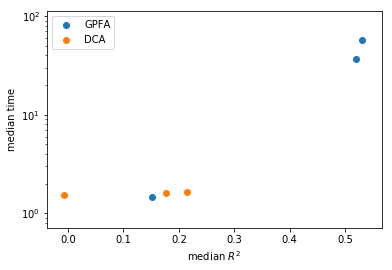

In [21]:
plt.scatter(np.median(r2[0, :, :, 1], axis=-1), np.median(times[0], axis=-1), label='GPFA')
plt.scatter(np.median(r2[1, :, :, 1], axis=-1), np.median(times[1], axis=-1), label='DCA')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(times.min() / 2, times.max() * 2)
plt.xlabel(r'median $R^2$')
plt.ylabel('median time')

In [ ]:
reload(mc)

gpfa = mc.GaussianProcessFactorAnalysis(n_factors=2, verbose=True, tol=1e-4)
gpfa.fit(X)

FA log likelihood: -8139.531780530168
EM update log likelihood: -5555.6964655277625

EM update log likelihood: -5154.244740881504

EM update log likelihood: -4748.679209087559

EM update log likelihood: -4483.9802472677275

EM update log likelihood: -4329.898610142343

EM update log likelihood: -4248.293533350408

EM update log likelihood: -4204.274048178426

EM update log likelihood: -4174.558065084444

EM update log likelihood: -4150.366841535451

EM update log likelihood: -4128.626931403697

EM update log likelihood: -4108.0875637017325

EM update log likelihood: -4087.620251213958

EM update log likelihood: -4066.05871663163

EM update log likelihood: -4042.757943340658



In [ ]:
reload(cca)
cca_model = cca.ComplexityComponentsAnalysis(d=2, T=5, n_init=5)
cca_model.estimate_cross_covariance(X, regularization='kron')

In [ ]:
cca_model.fit_projection()

In [ ]:
print(gpfa.C_)
print(subspace_angles(proj, gpfa.C_))
Xt = gpfa.transform(X)
model = LR().fit(X[:, :2], Xt)
model.score(X[:, :2], Xt)

In [ ]:
print(cca_model.coef_)
print(subspace_angles(proj, cca_model.coef_))
Xt = cca_model.transform(X)
model = LR().fit(X[:, :2], Xt)
model.score(X[:, :2], Xt)